# Fine-Tune with MNIST

Follow steps below to get started with a jupyter notebook for how to train a Towhee operator. This example fine-tunes a pretrained model (eg. resnet-18) with the MNIST dataset.

# 1. Download Operator
Download operator files together with the jupyter notebook.

In [1]:
! git clone https://towhee.io/towhee/resnet-image-embedding.git
%cd resnet-image-embedding
%ls

Cloning into 'resnet-image-embedding'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 220 (delta 119), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (220/220), 908.00 KiB | 279.00 KiB/s, done.
Resolving deltas: 100% (119/119), done.
/media/supermicro/DATA1/zhangchen_workspace/towhee_examples/resnet-image-embedding
examples/                     requirements.txt
ILSVRC2012_val_00049771.JPEG  resnet_image_embedding.py
__init__.py                   resnet_image_embedding.yaml
README.md                     resnet_training_yaml.yaml


Then run Python scripts in following steps to train and test a Towhee operator.
# 2. Setup Operator
Create operator and load model by name.

In [2]:
# import sys
# sys.path.append('..')

from resnet_image_embedding import ResnetImageEmbedding

# Set num_classes=10 for MNIST dataset
op = ResnetImageEmbedding('resnet18', num_classes=10)

# 3. Configure Trainer:
Modify training configurations on top of default values.

In [3]:
from towhee.trainer.training_config import TrainingConfig

training_config = TrainingConfig(
    batch_size=64,
    epoch_num=2,
    output_dir='mnist_output'
)

# 4. Prepare Dataset
The example here uses the MNIST dataset for both training and evaluation.

In [4]:
from torchvision import transforms
from towhee import dataset
from torchvision.transforms import Lambda
mean = 0.1307
std = 0.3081
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                          Lambda(lambda x: x.repeat(3, 1, 1)),
                                          transforms.Normalize(mean=[mean] * 3, std=[std] * 3)])
train_data = dataset('mnist', transform=mnist_transform, download=True, root='data', train=True)
eval_data = dataset('mnist', transform=mnist_transform, download=True, root='data', train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# 5. Start Training
Start to train mnist, it will take about 30-100 minutes on a cpu machine. If you train on a gpu machine, it will be much faster.

In [5]:
op.train(training_config, train_dataset=train_data, eval_dataset=eval_data)

2022-03-23 13:07:32,089 - 140043302467392 - trainer.py-trainer:319 - WARNING: TrainingConfig(output_dir='mnist_output', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=64, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=None, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': None, 'comment': ''}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, sync_bn=False, freeze_bn=False)
[epoch 1/2] loss=0.197, metric=0.947, eval_loss=0.176, eval_metric=0.989: 100%|███████████████████████████████████████████████████| 937/937 [00:39<00:00, 23.83step/s]
[epoch 2/2] loss=0.042, metric=0.993, eval_loss=0.043, eval_metric=0.99: 100%|████████████████████████████████████

Observing epoch progress bars, if loss decreases while metric increases, then you are training the model properly.
# 6. Predict after Training
After training, you can make new predictions with the operator. Comparing new predicted results with actual labels, you can evaluate the fine-tuned model with accuracy.



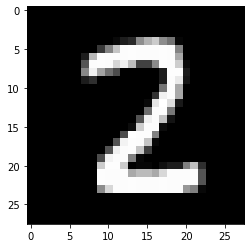

this picture is number 2


In [6]:
import matplotlib.pyplot as plt
import torch
import random

# get random picture and predict it.
img_index = random.randint(0, len(eval_data))
img = eval_data.dataset[img_index][0]
img = img.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
pil_img = img * std + mean
plt.imshow(pil_img)
plt.show()
test_img = eval_data.dataset[img_index][0].unsqueeze(0).to(op.trainer.configs.device)
out = op.trainer.predict(test_img)
predict_num = torch.argmax(torch.softmax(out, dim=-1)).item()
print('this picture is number {}'.format(predict_num))